## Import

In [240]:
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data
from tqdm.notebook import tqdm
import datetime
import pandas as pd

In [378]:
start_date = "20180101"
end_date = "20200101"

AAPL = data.get_data_yahoo("AAPL", start_date, end_date)
XOM = data.get_data_yahoo("XOM", start_date, end_date)
PFE = data.get_data_yahoo("PFE", start_date, end_date)
BA = data.get_data_yahoo("BA", start_date, end_date)

asset1 = AAPL["Close"].to_numpy()
asset2 = XOM["Close"].to_numpy()
asset3 = PFE["Close"].to_numpy()
asset4 = BA["Close"].to_numpy()

# Risk free rate in 2020
Rf = data.get_data_yahoo("^TNX", start_date, end_date)
Rf_mean = Rf["Adj Close"].mean() / 100

In [379]:
AAPL

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,43.075001,42.314999,42.540001,43.064999,102223600.0,41.442081
2018-01-03,43.637501,42.990002,43.132500,43.057499,118071600.0,41.434864
2018-01-04,43.367500,43.020000,43.134998,43.257500,89738400.0,41.627323
2018-01-05,43.842499,43.262501,43.360001,43.750000,94640000.0,42.101261
2018-01-08,43.902500,43.482498,43.587502,43.587502,82271200.0,41.944889
...,...,...,...,...,...,...
2019-12-24,71.222504,70.730003,71.172501,71.067497,48478800.0,70.459007
2019-12-26,72.495003,71.175003,71.205002,72.477501,93121200.0,71.856941
2019-12-27,73.492500,72.029999,72.779999,72.449997,146266000.0,71.829674


In [380]:
# missing_dates = list(set(AAPL.index) - set(Rf.index))
# Rf_temp = Rf.copy()
# for missing_date in missing_dates:
#     df_temp = pd.DataFrame(
#     data = {
#         "Date": [missing_date],
#         "High": [Rf.loc[missing_date - datetime.timedelta(days=7)]["High"]],
#         "Low": [Rf.loc[missing_date - datetime.timedelta(days=7)]["Low"]],
#         "Open": [Rf.loc[missing_date - datetime.timedelta(days=7)]["Open"]],
#         "Close": [Rf.loc[missing_date - datetime.timedelta(days=7)]["Close"]],
#         "Volume": [Rf.loc[missing_date - datetime.timedelta(days=7)]["Volume"]],
#         "Adj Close": [Rf.loc[missing_date - datetime.timedelta(days=7)]["Adj Close"]],
#     }
# ).set_index("Date")
#     Rf_temp = Rf_temp.append(df_temp)
# Rf_imputed = Rf_temp.sort_index()
# Rf_imputed

## Portfolio weight

In [443]:
# Create the weights
def randomWeightGen(n=4):
    w = np.random.random(n)
    return w / w.sum()

def rateOfReturn(asset:np.array):
    return asset[1:] / asset[:-1] - 1

def portfolio(w:np.array, *assets):
    assert len(w) == len(assets)
    return np.dot(w, np.array(assets)) 


## Covariance Matrix $\Sigma$

In [444]:
assets_daily_return = np.array([rateOfReturn(asset) for asset in [asset1, asset2, asset3, asset4]])

Sigma = np.cov(assets_daily_return, ddof=0)
Sigma

array([[3.00611355e-04, 9.46731642e-05, 7.83552868e-05, 1.42100548e-04],
       [9.46731642e-05, 1.63081583e-04, 6.18419311e-05, 1.01275757e-04],
       [7.83552868e-05, 6.18419311e-05, 1.49986118e-04, 6.29508317e-05],
       [1.42100548e-04, 1.01275757e-04, 6.29508317e-05, 3.61898656e-04]])

In [445]:
R = np.mean(assets_daily_return, axis=1)* 253 

## Monte Carlo

In [446]:
x = []
y = []

for i in tqdm(range(30000)):
    asset = portfolio(randomWeightGen(4), asset1, asset2, asset3, asset4)
    x.append(np.std(rateOfReturn(asset)) * np.sqrt(253))
    y.append(np.mean(rateOfReturn(asset)) * 253)

In [447]:
# idx_max = np.argmax(list(map(lambda a: a[1]/a[0], zip(x,y))))
# x[idx_max], y[idx_max]

In [448]:
# plt.figure(figsize=(12,8))
# plt.grid()

# plt.scatter(x, y)
# a = np.linspace(0,0.2,100)
# plt.plot(a, 1.65*a + Rf_mean, color="red")
# plt.show()

## Analytical Solution to the Minimization problem
$$\begin{bmatrix}2\Sigma &-R & -{\bf1}\\ R^T &0 & 0 \\ {\bf1}^T &0 &0 \end{bmatrix} * \begin{bmatrix}w\\\lambda_1\\\lambda_2\end{bmatrix} = \begin{bmatrix}0\\\mu \\ 1\end{bmatrix}$$



In [449]:
n = 4
# The matrix on the left
mat1 = np.vstack(
    [
        np.hstack([2*Sigma, -np.expand_dims(R,axis=1), -np.ones((n,1))]),
        np.hstack([R, [0], [0]]),
        np.hstack([np.ones(n), [0], [0]])
    ]
)

arr_mu = np.linspace(0, 0.4, 5000)
arr_volatility = []
arr_w = []


for mu in arr_mu:
    # vec2 = np.array([0] * n + [mu] + [1])
    # # np.linalg.solve only solves n×n
    # w_lambda = np.linalg.lstsq(mat1, vec2)[0]

    vec2 = np.array([0] * n + [mu] + [1])
    w_lambda = np.linalg.solve(mat1, vec2)

    w = w_lambda[:n]
    arr_w.append(w)
    volatility = np.sqrt(np.dot(w, np.dot(Sigma, w))) * np.sqrt(253)
    arr_volatility.append(volatility)
arr_volatility = np.array([arr_volatility]).squeeze()

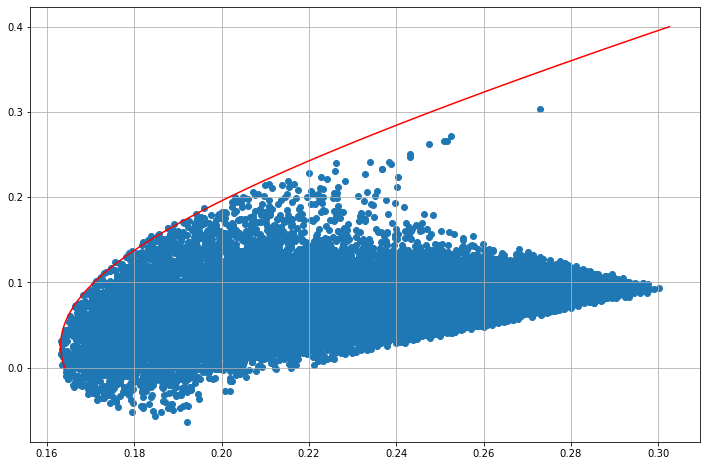

In [450]:
plt.figure(figsize=(12,8))
plt.grid()
plt.plot(arr_volatility, arr_mu, color="Red")

plt.scatter(x, y)
# a = np.linspace(0,0.2,100)
# plt.plot(a, 1.65*a + Rf_mean, color="red")
plt.savefig("Efficient Frontier.jpg")
plt.show()
